<a href="https://colab.research.google.com/github/kartikeyaj0/anime-genre-prediction/blob/main/anime_genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project I will be trying to predict the genre for animes using their synopsis. We have used the MyAnimeList api (https://myanimelist.net/apiconfig/references/api/v2) to fetch the data. Please refer to the *'fetch_data.py'*. We will be using TF-IDF to convert the synopsis into a document matrix, and compare the performance of logistic regression, linear support vector classifier, and random forests on this dataset.

# Imports

We begin by importing all the necessary modules:

In [1]:
import json
import os
import re

from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Fetching the data

We will be cloning the project repository that contains the api responses saved as json files. An example of an api response is as follows:

{"id": 1, "title": "Cowboy Bebop", "synopsis": "In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as \"Cowboys.\" The ragtag team aboard the spaceship Bebop are two such individuals.\n \nMellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels\u2014Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong\u2014the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little.\n\nWell-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after.\n\n[Written by MAL Rewrite]", "genres": [{"id": 1, "name": "Action"}, {"id": 2, "name": "Adventure"}, {"id": 4, "name": "Comedy"}, {"id": 8, "name": "Drama"}, {"id": 24, "name": "Sci-Fi"}, {"id": 29, "name": "Space"}]}

We see that the response (in general)has four fields:
* id: Unique identifier in the MyAnimeList database
* title: Name of the anime
* synopsis: A brief summary of the anime
* genres: A list of genres that best describe the anime

Since fetching the data from the api takes a long time (due to rate limitations), we will use the pre-fetched data from our repository. The *'fetch_data.py'* script scans through ids 1 to 40000, and fetches data for the valid ids. We discard any responses with synopsis of length less than 200 characters.

In [2]:
!git clone https://github.com/kartikeyaj0/anime-genre-prediction.git
os.chdir('anime-genre-prediction')

Cloning into 'anime-genre-prediction'...
remote: Enumerating objects: 9650, done.
remote: Counting objects: 100% (9650/9650), done.
remote: Compressing objects: 100% (9613/9613), done.
remote: Total 9650 (delta 47), reused 9612 (delta 23), pack-reused 0
Receiving objects: 100% (9650/9650), 23.67 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (47/47), done.


# Compile the API responses

We begin by loading the response json files into python lists

In [3]:
anime_id = []
anime_title = []
anime_synopsis = []
anime_genres = []

# List all the data files
file_list = os.listdir('data')

# Read all the files
for filename in file_list:
    try:
        with open('data/{}'.format(filename)) as f:
            tmp = json.load(f)
        anime_id.append(tmp.get('id'))
        anime_title.append(tmp.get('title'))
        anime_synopsis.append(tmp.get('synopsis'))
        anime_genres.append(tmp.get('genres'))
    except Exception:
        raise Exception('Error reading the file {}'.format(filename))

We now create a pandas dataframe for our data

In [4]:
data = pd.DataFrame({'id': anime_id,
                     'title': anime_title,
                     'synopsis': anime_synopsis,
                     'genres': anime_genres})

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        9517 non-null   int64 
 1   title     9517 non-null   object
 2   synopsis  9517 non-null   object
 3   genres    9494 non-null   object
dtypes: int64(1), object(3)
memory usage: 297.5+ KB
None


Since each 'id' is unique, there are no duplicates in the data. We can see that some entries do not have 'genres' populated. We will be dropping these entries.

In [5]:
data.dropna(inplace=True)

We can also drop id and title columns as we will not be using them

In [6]:
data.drop(['id', 'title'], axis=1, inplace=True)

# Visualize Synopsis Length

Let's visualize the distribution of synopsis lengths

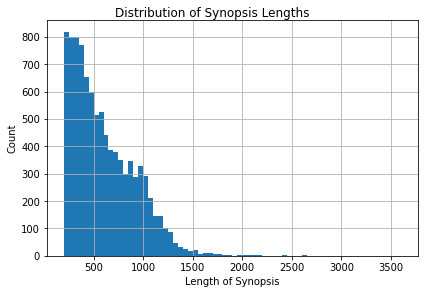

In [7]:
synopsis_len = data.synopsis.str.len()
fig, ax = plt.subplots(1, 1)
synopsis_len.hist(
    bins=np.arange(min(synopsis_len) - 1, max(synopsis_len) + 1, 50), ax=ax)
ax.set_xlabel('Length of Synopsis')
ax.set_ylabel('Count')
fig.suptitle('Distribution of Synopsis Lengths',y=1.01)
plt.tight_layout()
plt.show()

# One-Hot Encoding
We will now generate One-hot encoding vectors for the genres

In [8]:
for index, row in data.iterrows():
    for genre in row.genres:
        if not genre['name'] in data:
            data[genre['name']] = 0
        data[genre['name']][index] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


We can now drop the genres column

In [9]:
data.drop('genres', axis=1, inplace=True)

# Visualizing data distribution

Text(0.5, 0.99, 'Distribution of data across genres')

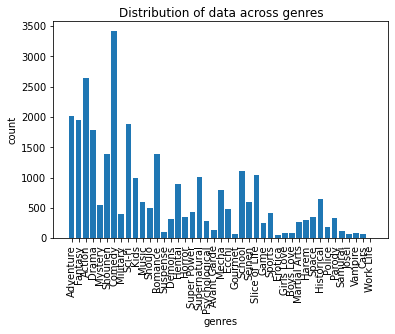

In [10]:
genre_count = data.sum(numeric_only=True)

# Plotting the data distribution
plt.bar(genre_count.index, genre_count)
plt.xlabel('genres')
plt.ylabel('count')
plt.xticks(rotation = 90)
plt.title('Distribution of data across genres', y=0.99)

We see the difference in scale of the values. Let's plot the data on a log scale

Text(0.5, 0.99, 'Distribution of data across genres')

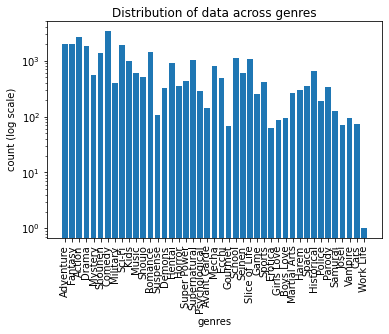

In [11]:
# Log Scale plot
plt.bar(genre_count.index, genre_count, log=True)
plt.xlabel('genres')
plt.ylabel('count (log scale)')
plt.xticks(genre_count.index, rotation='vertical')
plt.title('Distribution of data across genres', y=0.99)

We see that the data is very imbalanced and some genres have a very low number
of entries. For the project we will keep only the genres which have more
than 400 entries.

In [12]:
genre_count = genre_count[genre_count > 400]
data = data[data.columns.intersection(
    ['synopsis'] + genre_count.index.tolist())]

Let's plot the new data distribution

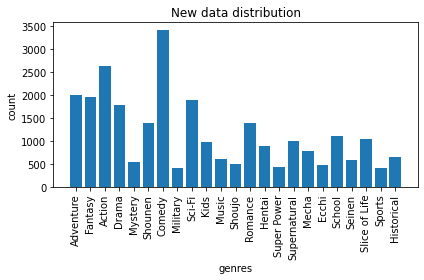

In [13]:
plt.bar(genre_count.index, genre_count)
plt.xlabel('genres')
plt.ylabel('count')
plt.xticks(genre_count.index, rotation='vertical')
plt.title('New data distribution')
plt.tight_layout()

We will drop the rows that only have zeros left in remaining genres

In [14]:
data = data[data.sum(axis=1, numeric_only=True) != 0]

Let's take a look at the correlation between genres

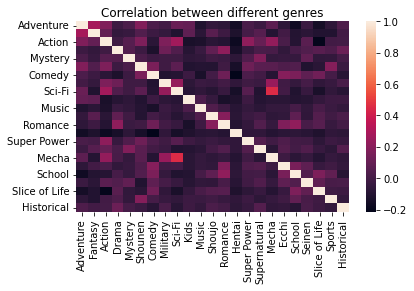

In [15]:
fig, axs = plt.subplots(1, 1)
sn.heatmap(data[data.columns.intersection(genre_count.index)].corr(), ax=axs)
fig.show()
fig.suptitle('Correlation between different genres', y=1)
fig.tight_layout()

# Preprocessing synopsis

As part of preprocessing, we will be doing the following steps:



## 1. Remove Source from synopsis
Many entries have the source cited for the synopsis from various databases. For eg. Source: Wikipedia, Source: ANN, (Source: ANN), Source AnimeDB, etc. Some entries also give credit to people who wrote the synopsis, eg. [Written by XYZ]

In [16]:
if any(data.synopsis.apply(lambda x: 'Source' in x)):
    data.synopsis = data.synopsis.apply(
        lambda x: re.sub(
            r'[\[\(\s]*Source[:\s]*.*[\]\)\s]*|\[[W]ritten.*\]', '', x))
if any(data.synopsis.apply(lambda x: 'Source' in x)):
    raise Exception('Error cleaning')
if any(data.synopsis.apply(lambda x: '[Written' in x)):
    raise Exception('Error cleaning')

## 2. Replace numbers
We replace numeric words with NUM. For eg: 1st, 4th, 1,000, 8.12, 100,000th, 1920s etc.

In [17]:
data.synopsis = data.synopsis.apply(
    lambda x: re.sub(r'\d[\d.,]*(st|rd|th)?|\d[\d.,]*(s)?', ' NUM ', x))

## 3. Stemming
We use PorterStemmer from nltk for stemming

In [18]:
stemmer = PorterStemmer()
data.synopsis = data.synopsis.apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

## 4. Generating Document Matrix

This involves tokenizing, stop-word removal, N-gram generation and tf-idf calculation

In [19]:
# Create a list of stop words
nltk.download('stopwords')
stops = set(stopwords.words("english"))

tokenizer = TfidfVectorizer().build_tokenizer()
regex_tokenizer = RegexpTokenizer(r'\w+')
# Use Unigrams, Bigrams as features
vectorizer = TfidfVectorizer(tokenizer=regex_tokenizer.tokenize,
                             stop_words=stops,
                             ngram_range=(1, 2),
                             max_features=10000)

document_matrix = vectorizer.fit_transform(data.synopsis)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We can now drop the synopsis column from the data

In [20]:
data.drop('synopsis', axis=1, inplace=True)

# Training prediction models

In this section, we will be building models using logitic regression, linear support vector classifier

## Logistic Regression

In [21]:
def logistic_regression(x_train, y_train, x_test, y_test, categories):
    clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
    clf.fit(x_train, y_train)
    prob_matrix = clf.predict_proba(x_test)

    # For this problem, we will predict only one genre with max probability
    # and verify if the entry belongs to that genre
    predicted_labels = np.argmax(prob_matrix, axis=1)

    tmp = y_test
    tmp['predicted'] = predicted_labels

    count = 0
    for i, row in tmp.iterrows():
        if row[categories[row.predicted]] == 1:
            count += 1

    custom_score = count/len(predicted_labels)
    return custom_score

## Linear Support Vector Classifier

In [22]:
def svc(x_train, y_train, x_test, y_test, categories):
    clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
    clf.fit(x_train, y_train)
    predicted_matrix = clf.predict(x_test)

    # Find the count of cases where at least one of the genres
    # matches the original
    df = pd.DataFrame(predicted_matrix, index=y_test.index)
    new = pd.DataFrame(
        y_test.values*df.values, columns=y_test.columns, index=y_test.index)
    count = np.count_nonzero(new.sum(axis=1))

    custom_score = count/len(predicted_matrix)
    return custom_score

## Random Forests

In [23]:
def random_forests(x_train, y_train, x_test, y_test, categories):
    clf = OneVsRestClassifier(RandomForestClassifier(), n_jobs=1)
    clf.fit(x_train, y_train)
    prob_matrix = clf.predict_proba(x_test)

    # For this problem, we will predict only one genre with max probability
    # and verify if the entry belongs to that genre
    predicted_labels = np.argmax(prob_matrix, axis=1)

    tmp = y_test
    tmp['predicted'] = predicted_labels

    count = 0
    for i, row in tmp.iterrows():
        if row[categories[row.predicted]] == 1:
            count += 1

    custom_score = count/len(predicted_labels)
    return custom_score

## K-Fold cross validation

Since are data is inbalanced and cannot be divided easily into train and test sets using stratify, we will be using K-fold cross validation. This will help reduce the variance.

In [24]:
def k_fold(x, y, k, classifier_function):
    categories = y.columns
    scores = []
    # Custom k-fold
    for i in range(k):
        # Split data into training and testing
        x_train, x_test = train_test_split(
            x, random_state=i, test_size=0.3, shuffle=True)
        y_train, y_test = train_test_split(
            y, random_state=i, test_size=0.3, shuffle=True)
        scores.append(classifier_function(
            x_train, y_train, x_test, y_test, categories))
    print('scores: {}\n\tavg: {}, \n\tmax: {}, \n\tmin: {}'.format(
        scores, np.mean(scores), max(scores), min(scores)))


In [25]:
k_fold(document_matrix, data, 10, logistic_regression)

scores: [0.6549019607843137, 0.6402852049910873, 0.669162210338681, 0.6631016042780749, 0.6598930481283423, 0.6452762923351159, 0.6395721925133689, 0.6663101604278074, 0.6424242424242425, 0.6520499108734403]
	avg: 0.6532976827094474, 
	max: 0.669162210338681, 
	min: 0.6395721925133689


In [26]:
k_fold(document_matrix, data, 10, svc)

scores: [0.6727272727272727, 0.6666666666666666, 0.6805704099821747, 0.6787878787878788, 0.6805704099821747, 0.6787878787878788, 0.6609625668449198, 0.6777183600713013, 0.6709447415329768, 0.6655971479500892]
	avg: 0.6733333333333333, 
	max: 0.6805704099821747, 
	min: 0.6609625668449198


In [ ]:
k_fold(document_matrix, data, 10, random_forests)